### IMPORT MODULES 

In [2]:
#! IMPORT AND WARNINGS
%matplotlib widget

import numpy as np
import math
import scipy.sparse
import scipy.sparse.linalg
import scipy.interpolate
import scipy.integrate 
import matplotlib.pyplot as plt
import time
import warnings
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path

OUTPUT_DIR = Path('SPL_data')
OUTPUT_DIR.mkdir(exist_ok=True)


warnings.filterwarnings("ignore", message="invalid value encountered in log10")
warnings.filterwarnings("ignore", message="divide by zero encountered in log10")
warnings.filterwarnings("ignore", message="divide by zero encountered in divide")
warnings.filterwarnings("ignore", message="invalid value encountered in divide")
warnings.filterwarnings("ignore", message="invalid value encountered in cast")
warnings.filterwarnings("ignore", message="invalid value encountered in sqrt")
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", category=scipy.sparse.SparseEfficiencyWarning)

### XHN PARSER

In [3]:
#! XHN PARSER
from modules.xhn_parser import import_xhn_complex, dPhi_default, dTheta_default

### Helper Functions

In [4]:
#! HELPER FUNCTIONS
from modules.mach import Mach
from modules.acoustics import sourceSalomons_order2_1D, fast_turb_3D, main_calc_3D_ADI_s1, interpolation_3D, gen_range, SetAtmos3D, roughness, Miki
from modules.visualization import plot_starter_field, plot_xy_slice
from modules.directivity_utils import berechne_lphi_ex

### Initial Parameters

In [5]:
#! -------- PARAMETERS ---------------

#// --------------------------------------------------------------------------------
#* SOURCE PARAMETERS
SOURCE_TYPE = "SALOMONS_XHN_MASK" 
XHN_FILE_PATH = 'S33-Arc100m.xhn' #'V36_FullSystem.xhn'
freq = 31.5 
safe_freq = np.maximum(freq, 1e-9)          # Source frequency (Hz)
hS_source_z = 1.2                                    # source height (m)
sigma_y_source_width = 12                          # SOURCE WIDTH

CALIBRATE_OUTPUT = True 
CALIBRATION_SPL_AT_DISTANCE = 43.5                       # expected value at calibration point (dB) #todo: check if its linear value
CALIBRATION_DISTANCE = 80.0                             # distance between calib. point and sound source (m)
CALIBRATION_POINT_Y_OFFSET = 0.0                        # If 0 then calibration point is on-axis
CALIBRATION_POINT_Z_HEIGHT = 1.8                        # only used if CALIBRATE_OUTPUT=true #! ACTIVE ROLE in the model

#// --------------------------------------------------------------------------------
#* MEDIUM PROPERTIES
#? Atmospheric parameters [variables]
T_Celsius = 10.0;                     # atmospheric temperatur (°C)
Tlog_coeff = 0.2 #0.2;                     # temperature coefficient for log temperature profil -0.5<Tlog<0.5. if 0 no profil
shear_exp = 0.15                      # wind shear exponents (scalar) for power law wind profil see [van den Berg 2008]
v_ref = 5.0;                          # % wind speed (m/s) measured at z_ref_wind_profile height, for power-law wind profile
z_ref_wind_profile = 80.0             # reference height for wind speed v_ref
theta_deg = 0.0;                       # propagation angle with respect to the source (0° : downwind, 180° : upwind)
f_turb_ind = False;                     # logical 'true' or 'false' to account for turbulence or not
gamT_turbulence = 0.01                  # turbulence strength used in "fast_turb" function. gamT = (CT/T0)^2 + 22/3 (Cv/c0)^2, e.g. [van Renterghem et al 2022]

#? General constant [fixed values]
Patm_Pa = 101325.0;                     # atmospheric pressure (Pa)
Rg_gas_const = 286.6896552;             # perfect gas constant (Rg=R/M=8.314E3/29)
gam_heat_ratio = 1.41                   #  % heat ratio
hr_humidity = 0.8;                      # relative humidity of air 0<hr<1
temp0_K = 273.15 + T_Celsius            #  % temperature (K)

#? Acoustic parameters [fixed values]
c0_sound_speed = np.sqrt(gam_heat_ratio * Rg_gas_const * temp0_K)               # adiabatic sound speed (m.s-1)
lambda_wavelength = c0_sound_speed / safe_freq                                     # wavelength (m)
k0_wavenumber = 2.0 * np.pi * safe_freq / np.maximum(c0_sound_speed, 1e-12)      # adiabatic wavenumber (rad/m)

#// --------------------------------------------------------------------------------
#* SPATIAL GRID 3D(x,y,z) [variables] - Propagation Media characteristic
dim_x = 250.0;                     # horizontal dimension x of the domain (m)
dim_y = 160.0;                      # transversal dimension x of the domain (m)
dim_z = 10.0                         # vertical dimension z of the domain (m)

#? Absorbing layer parameters [fixed values]
haut_a_z_absrp = 0.8; coeff_a_z_absrp = 10.0   # absorbing layer starts at the top of the domain, according to z axis (0.8 ==> start at 80% of z axis) + damping rate
haut_a_y_absrp = 0.8; coeff_a_y_absrp = 10.0   # absorbing layer starts at the laterals of the domain, according to y axis (0.8 ==> start at 80% of y axis) + damping rate

#? Spatial Discretization variables [e.g. for 20Hz works 20, for freqs > 125 don't go too low (<6)]
discr_pts_per_lambda = 7.0 
discr_pts_per_lambda_z = 10.0

#? Numerical parameters [fixed values (aka calculated)]
# Following spatial discretization steps for calculation (m)
delta_x = lambda_wavelength/discr_pts_per_lambda if discr_pts_per_lambda!=0 and not np.isinf(lambda_wavelength) else (dim_x/10 if dim_x>0 else 0.1)
delta_z = lambda_wavelength/discr_pts_per_lambda_z if discr_pts_per_lambda_z!=0 and not np.isinf(lambda_wavelength) else (dim_z/10 if dim_z>0 else 0.1)
delta_y = lambda_wavelength/discr_pts_per_lambda if discr_pts_per_lambda!=0 and not np.isinf(lambda_wavelength) else (dim_y/10 if dim_y>0 else 0.1)
# securing deltas
if delta_x<=1e-6:delta_x=0.1
if delta_z<=1e-6:delta_z=0.1
if delta_y<=1e-6:delta_y=0.1

# number of points in the domain along x,y,z
x_coords_temp = gen_range(0, delta_x, dim_x)
if len(x_coords_temp)==0 and dim_x>=0: x_coords_temp=np.array([0.0])
if len(x_coords_temp)>0 and x_coords_temp[-1]<dim_x-1e-9*delta_x: x_coords_temp=np.append(x_coords_temp,dim_x)
if len(x_coords_temp)==1 and dim_x>x_coords_temp[0]+1e-9: x_coords_temp=np.array([x_coords_temp[0],dim_x]) 
x_coords = np.unique(x_coords_temp)
nb_x=len(x_coords)
# +++++++++++++++ Y +++++++++++++++++
nb_y_calc = int(np.floor(dim_y/delta_y))+1
y_coords = np.linspace(-dim_y/2.0, dim_y/2.0, nb_y_calc) 
nb_y = len(y_coords)
yS_source_y_center = 0.0  
# +++++++++++++++++ Z ++++++++++++++++
z_coords = (np.arange(int(np.floor(dim_z/delta_z))+1))*delta_z 
nb_z = len(z_coords)
# Ensure number of points in the domain are minimum 3
nb_x=np.maximum(nb_x,3); nb_y=np.maximum(nb_y,3); nb_z=np.maximum(nb_z,3)

#? Spatial discretization step along x,y and z for saving data (m)
stock_x_save_step = 1.0
stock_y_save_step = 1.0
stock_z_save_step = 0.5
z_r_receiver_height = 1.5   #  receiver height for plotting (m)

#// -----------------------------------------------------------------------------------------------------
#* GROUND PROPERTIES [variables]
hv_veg = 0.0                            # vegetation height (m), it affects the shape of atmospheric profils
z0_rough_len = 0.13*hv_veg + 1e-5       #% atmospheric roughness length (m), can't be null
d_disp_h = 0.66*hv_veg                  # displacement height of flux profiles (m), it's directly linked to vegetation height
lc_ground_corr = 0.0                    #% correlation length (ground roughness parameter), if 0 : no ground rugositiy [0.05-1] (m) 
sigmah_ground_std = 0.0                 # standard deviation of roughness height (ground roughness parameter) [0.01-0.05] (m)  %
sigma_airflow_res = 1000.0              # airflow resistivity of the ground
h_ground_layer = 0.0                    # thickness of ground surface layer (m), if h = 0 no layer
incidence_angle_gr = np.pi / 2.0        #! % wave incidence angle on the ground, pi/2 : incidence rasante  [fixed value]

#// -------------------------------------------------------------------------------------------------------
# TODO: the next seems to be not used correctly
theta_rad = np.deg2rad(theta_deg) 
pa_kpa_atmos = Patm_Pa / 1000.0   # TODO: why to kPa (ref=101.325) in accordance to ISO9613-2

#// ---------------------------------------------------------------------------------------------------------
print(f"Grid: nx={nb_x}, ny={nb_y}, nz={nb_z}")
print(f"Deltas: dx={delta_x:.3f}, dy={delta_y:.3f}, dz={delta_z:.3f}")
if nb_x > 0 and nb_y > 0 and nb_z > 0:
    print(f"Coords: x spans {x_coords[0]:.2f}-{x_coords[-1]:.2f}, y spans {y_coords[0]:.2f}-{y_coords[-1]:.2f}, z spans {z_coords[0]:.2f}-{z_coords[-1]:.2f}")
else:
    print("Warning: One or more coordinate arrays are empty.")

Grid: nx=164, ny=105, nz=10
Deltas: dx=1.534, dy=1.534, dz=1.074
Coords: x spans 0.00-250.00, y spans -80.00-80.00, z spans 0.00-9.67


### MAIN EXECUTION

Using Salomons starter (direct wave only, Rp=0) masked by XHN directivity.
Baseline Salomons-spherical field created.
Successfully processed frequency 31.5 Hz (TMFEx index 0) found at line 348
Using XHN directivity mask for 31.5 Hz.
Mapping XHN directivity for mask...
Salomons source masked with XHN directivity.


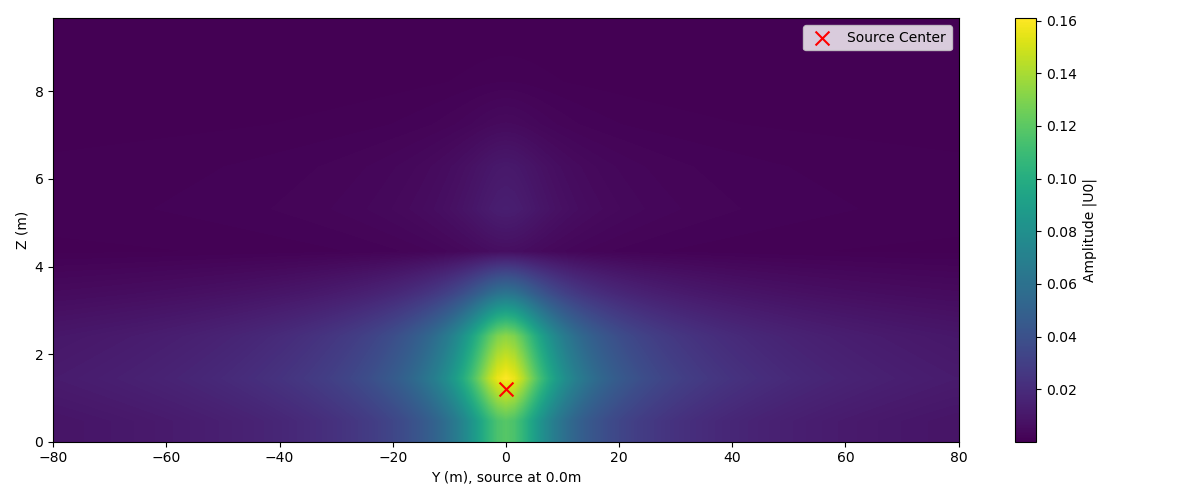

Starting 3D ADI calculation...
3D ADI calculation finished.
Pressure field calculated for 162 x-slices.
Interpolating complex pressure field...
Interpolation finished.
Applying atmospheric absorption (using SetAtmos3D)...
Atmospheric absorption applied.
Calibrating output: Target SPL=43.50 dB at dist=80.00m, y_offset_from_center=0.00m, z_h=1.80m.
  Actual calibration point in model grid: x=79.53m, y=0.00m (rel to y_center), z=2.00m
  Model relative SPL at cal point (after atmos/turb): -31.54 dB
  Calculated Calibration Offset: 75.04 dB
  Output calibration applied.
Effective SPL at 1m for DeltaL calc: 81.56 dB
Total elapsed time: 7.08 seconds


In [6]:
#! --------- MAIN EXECUTION ---------------
start_time = time.time()

#//                                                                                            
#* GROUND Admittance calculation 
# Beta_ground_val = effective admittance
Beta_ground_val = Miki(freq, k0_wavenumber, sigma_airflow_res, h_ground_layer) + \
                    roughness(lc_ground_corr, sigmah_ground_std, k0_wavenumber, incidence_angle_gr) #ground roughness effect on admittance
#Reflexion coefficient of ground
Rp_salomons_internal_reflection = (1.0 - Beta_ground_val) / (1.0 + Beta_ground_val + 1e-12)

#//                                                                                            
#* WIND PROFILE calculation
#? Optional: set the reference wind speed to zero v_ref = 0.0 to bypass/neutralize the numerical variables coefficients
#? Then, no mean flow
Mx_prof_vec, eps0_prof_vec, eps1_prof_vec = Mach(
    v_ref, z_ref_wind_profile, z_coords, 
    z0_rough_len, d_disp_h, shear_exp,
    c0_sound_speed, Tlog_coeff, temp0_K, Rg_gas_const, gam_heat_ratio, theta_deg 
)
Mx_prof_col = Mx_prof_vec.reshape(-1,1)
eps0_prof_col = eps0_prof_vec.reshape(-1,1)
eps1_prof_col = eps1_prof_vec.reshape(-1,1)

#//                                                                                            
#* NUMERICAL VARIABLES
# The next coefficients are mainly used in the Mach function
sqrt_arg_lorentz = 1 - Mx_prof_col**2    
gamma_x_lorentz_prof_col = 1./np.sqrt(np.maximum(sqrt_arg_lorentz,1e-12)+0j)
gamma_x_lorentz_prof_col = np.real(gamma_x_lorentz_prof_col) 
sqrt_arg_epsilon1 = 1 + eps1_prof_col 
tau_bar1_operator_prof_col = (Mx_prof_col * gamma_x_lorentz_prof_col**2) * \
                                (np.sqrt(np.maximum(sqrt_arg_epsilon1,0)+0j) - Mx_prof_col)
tau_bar1_operator_prof_col = np.real(tau_bar1_operator_prof_col) 

#//                                                                                            
#* STARTER PRESSURE FIELD
U0_3D_initial_plane = np.zeros((nb_z, nb_y), dtype=complex) 

#? Masked Source
if SOURCE_TYPE == "SALOMONS_XHN_MASK":
    print("Using Salomons starter (direct wave only, Rp=0) masked by XHN directivity.")
    U0_z_baseline = sourceSalomons_order2_1D(z_coords, hS_source_z, k0_wavenumber, Rp=0.0)  #! Rp_salomons_internal_reflection)
  
    #! spherical POINT source
    x0 = 6 
    r = np.sqrt(x0**2 + (y_coords - yS_source_y_center)**2)
    source_y_profile_spherical = 1.0 / r
    U0_baseline_2D = U0_z_baseline * source_y_profile_spherical.reshape(1, -1)   
    print("Baseline Salomons-spherical field created.")

    xhn_parsed_freqs, xhn_phi_deg_axis, xhn_theta_deg_axis, xhn_all_complex_data, final_magnitudes = \
        import_xhn_complex(XHN_FILE_PATH, TMFEx=[freq], dPhi=dPhi_default, dTheta=dTheta_default)
    if xhn_parsed_freqs.size == 0 or not np.isclose(xhn_parsed_freqs[0], freq):
        print(f"ERROR: Freq {freq} Hz not found/parsed from XHN for masking. Parsed: {xhn_parsed_freqs}. Exiting.")
        exit()
    source_directivity_complex_pattern =  xhn_all_complex_data[0, :, :] #full data
    current_xhn_freq = xhn_parsed_freqs[0] 
    print(f"Using XHN directivity mask for {current_xhn_freq} Hz.")
    
    #//------------------------------------------------------------------------------------------------------------------------------    
    #* MASKING THE SOURCE
    Rfar = np.power(sigma_y_source_width,2) / (2*(c0_sound_speed/freq)) # Farfield approximation
    D_complex_mask = np.zeros((nb_z, nb_y), dtype=complex)
    x_eff_projection = Rfar 
    print("Mapping XHN directivity for mask...")
    for iz_pe in range(nb_z):
        for iy_pe in range(nb_y):                 
            vec = [x_eff_projection, y_coords[iy_pe] - yS_source_y_center, z_coords[iz_pe] - hS_source_z]
            Lphi = berechne_lphi_ex(dPhi_default, dTheta_default, xhn_all_complex_data) #final_magnitudes)
            D_complex_mask[iz_pe, iy_pe] = 10**(Lphi[0]/20.0) 
                               
    U0_3D_initial_plane = U0_baseline_2D * D_complex_mask
    print("Salomons source masked with XHN directivity.")

    #* PLOTTING THE STATER FIELD
    plot_starter_field(U0_3D_initial_plane, y_coords, z_coords, yS_source_y_center, hS_source_z, current_xhn_freq)
    
else: 
    print("Using Salomons starter source (with ground reflection term for starter).")
    U0_z_profile = sourceSalomons_order2_1D(z_coords, hS_source_z, k0_wavenumber, Rp=0) #Rp_salomons_internal_reflection
    source_y_profile_gauss = np.exp(-y_coords**2 / (2.0 * sigma_y_source_width**2)) 
    U0_3D_initial_plane =  U0_z_profile *source_y_profile_gauss.reshape(1, -1)  
    print("Salomons-Gaussian source field generated.")
        
    plt.figure(figsize=(12, 5))
    plt.imshow(np.abs(U0_3D_initial_plane), aspect='auto', origin='lower', 
                extent=[y_coords[0], y_coords[-1], z_coords[0], z_coords[-1]],
                interpolation='bilinear')
    plt.colorbar(label='Amplitude |U0|')
    plt.xlabel(f'Y (m), source at {yS_source_y_center:.1f}m'); plt.ylabel('Z (m)')
    # plt.title(f'Initial Field Amp (JUST Salomons {freq} Hz)')
    if yS_source_y_center >= y_coords[0] and yS_source_y_center <= y_coords[-1] and \
        hS_source_z >= z_coords[0] and hS_source_z <= z_coords[-1]:
            plt.scatter(yS_source_y_center, hS_source_z, c='red', marker='x', s=100, label='Source Center')
    plt.legend();plt.tight_layout(); plt.show(block=False)
    
#//                                                                                            
#* ADI COMPUTATION
print("Starting 3D ADI calculation...")
Phi_potential_3D = main_calc_3D_ADI_s1(
    U0_3D_initial_plane, gamma_x_lorentz_prof_col, tau_bar1_operator_prof_col, 
    k0_wavenumber, delta_x, delta_z, delta_y,
    nb_x, nb_z, nb_y, 
    eps0_prof_col, eps1_prof_col, Beta_ground_val,
    haut_a_z_absrp, coeff_a_z_absrp, 
    haut_a_y_absrp, coeff_a_y_absrp
)
print("3D ADI calculation finished.")


#// ---------------------------------------------------------------------------------------------------------------
#* COMPUTING PRESSURE FIELD
idx_pressure_x_calc = np.arange(1, nb_x - 1) 
pressure_complex_3D_field_calc = np.zeros((nb_z, nb_y, len(idx_pressure_x_calc)), dtype=complex)
x_pressure_coords_1d_calc = np.array([])

if len(idx_pressure_x_calc) > 0:
    x_pressure_coords_1d_calc = x_coords[idx_pressure_x_calc] 
    
    Mx_bcast_P = Mx_prof_col.reshape(nb_z, 1, 1) 
    
    for i_calc, ix_pe in enumerate(idx_pressure_x_calc):
        Phi_n_i_slice = Phi_potential_3D[:, :, ix_pe]      
        Phi_prv_slice = Phi_potential_3D[:, :, ix_pe - 1]  
        Phi_nxt_slice = Phi_potential_3D[:, :, ix_pe + 1]  
        
        exp_term_prop_P = np.exp(1j * k0_wavenumber * x_coords[ix_pe]) 
        
        term1_p_calc = (1.0 - Mx_prof_col) * Phi_n_i_slice 
        term2_p_factor_calc = (1j * Mx_prof_col / (2.0 * k0_wavenumber * delta_x + 1e-12)) 
        term2_p_calc = term2_p_factor_calc * (Phi_nxt_slice - Phi_prv_slice) 
        
        pressure_complex_3D_field_calc[:, :, i_calc] = exp_term_prop_P * (term1_p_calc + term2_p_calc)
    print(f"Pressure field calculated for {len(idx_pressure_x_calc)} x-slices.")
else:
    print("Not enough x-points in Phi_potential_3D to calculate pressure field. Need at least 3 x-points in Phi.")


#// ------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#* COMPLEX PRESSURE FIELD INTERPOLATION
print("Interpolating complex pressure field...")
L_pp3D_complex_interp, x_pp_interp, y_pp_interp, z_pp_interp = interpolation_3D(
    pressure_complex_3D_field_calc, 
    stock_x_save_step, stock_y_save_step, stock_z_save_step,
    x_pressure_coords_1d_calc, y_coords, z_coords 
)
L_pp3D_dB_interp_relative = 20.0*np.log10(np.abs(L_pp3D_complex_interp) + 1e-16) 
print("Interpolation finished.")


#//---------------------------------------------------------------- -------------------------------------------------------------------------------------------------------
#* APPLYING ATMOSPHERIC ATTENUATION
print("Applying atmospheric absorption (using SetAtmos3D)...")
L_pp3D_atmos_relative = SetAtmos3D(L_pp3D_dB_interp_relative, x_pp_interp, y_pp_interp, z_pp_interp,
                                    hS_source_z, yS_source_y_center, 
                                    freq, hr_humidity, T_Celsius, pa_kpa_atmos)
print("Atmospheric absorption applied.")

L_pp3D_after_effects_relative = L_pp3D_atmos_relative.copy()
if f_turb_ind:
    print("Applying turbulence effects (using fast_turb_3D)...")
    L_pp3D_after_effects_relative = fast_turb_3D(L_pp3D_atmos_relative, 
                                                    x_pp_interp, y_pp_interp, z_pp_interp,
                                                    hS_source_z, yS_source_y_center, 
                                                    freq, gamT_turbulence)
    print("Turbulence effects applied.")


#// ----------------------------------------------------------------------------------------------------------------------------------------------------------------------
#* FINAL SPL 
L_pp3D_final_for_analysis = L_pp3D_after_effects_relative.copy()
if CALIBRATE_OUTPUT:
    print(f"Calibrating output: Target SPL={CALIBRATION_SPL_AT_DISTANCE:.2f} dB at dist={CALIBRATION_DISTANCE:.2f}m, y_offset_from_center={CALIBRATION_POINT_Y_OFFSET:.2f}m, z_h={CALIBRATION_POINT_Z_HEIGHT:.2f}m.")
    
    if x_pp_interp.size > 0 and y_pp_interp.size > 0 and z_pp_interp.size > 0:
        idx_x_cal = np.argmin(np.abs(x_pp_interp - CALIBRATION_DISTANCE))
        
        y_cal_target_on_grid = np.clip(yS_source_y_center + CALIBRATION_POINT_Y_OFFSET, y_pp_interp[0], y_pp_interp[-1])
        idx_y_cal = np.argmin(np.abs(y_pp_interp - y_cal_target_on_grid))
        
        z_cal_target_on_grid = np.clip(CALIBRATION_POINT_Z_HEIGHT, z_pp_interp[0], z_pp_interp[-1])
        idx_z_cal = np.argmin(np.abs(z_pp_interp - z_cal_target_on_grid))

        actual_cal_x = x_pp_interp[idx_x_cal]
        actual_cal_y = y_pp_interp[idx_y_cal] 
        actual_cal_z = z_pp_interp[idx_z_cal]
        print(f"  Actual calibration point in model grid: x={actual_cal_x:.2f}m, y={actual_cal_y:.2f}m (rel to y_center), z={actual_cal_z:.2f}m")

        if L_pp3D_after_effects_relative.ndim == 3 and \
            idx_z_cal < L_pp3D_after_effects_relative.shape[0] and \
            idx_y_cal < L_pp3D_after_effects_relative.shape[1] and \
            idx_x_cal < L_pp3D_after_effects_relative.shape[2]:
            
            spl_model_at_cal_point = L_pp3D_after_effects_relative[idx_z_cal, idx_y_cal, idx_x_cal]
            
            if np.isnan(spl_model_at_cal_point) or np.isinf(spl_model_at_cal_point):
                print("  Warning: Model SPL at calibration point is NaN or Inf. Calibration skipped.")
            else:
                calibration_offset = CALIBRATION_SPL_AT_DISTANCE - spl_model_at_cal_point
                print(f"  Model relative SPL at cal point (after atmos/turb): {spl_model_at_cal_point:.2f} dB")
                print(f"  Calculated Calibration Offset: {calibration_offset:.2f} dB")
                L_pp3D_final_for_analysis = L_pp3D_after_effects_relative + calibration_offset
                print("  Output calibration applied.")
        else:
            print("  Warning: Calibration point indices are out of bounds for the processed SPL field. Calibration skipped.")
    else:
        print("  Warning: Interpolated grid for calibration is empty. Calibration skipped.")
else:
    print("Output calibration not enabled. Using relative SPLs (after atmos/turb).")


#// ------------------------------------------------------------------------------------------------------------------------------------
DeltaL3D_atten_final = np.array([])
if L_pp3D_final_for_analysis.size > 0 and x_pp_interp.size > 0 and y_pp_interp.size > 0 and z_pp_interp.size > 0:
    ZI_plot, YI_plot, XI_plot = np.meshgrid(z_pp_interp, y_pp_interp, x_pp_interp, indexing='ij')
    R_3D_dist_from_origin = np.sqrt(XI_plot**2 + (YI_plot - yS_source_y_center)**2 + (ZI_plot - hS_source_z)**2 + 1e-9)
    
    if CALIBRATE_OUTPUT:
        SPL_source_at_1m_eff = CALIBRATION_SPL_AT_DISTANCE + 20 * np.log10(CALIBRATION_DISTANCE / 1.0)
        SPL_ff_mesh = SPL_source_at_1m_eff - 20 * np.log10(R_3D_dist_from_origin / 1.0 + 1e-9) # Added epsilon to R_3D
        DeltaL3D_atten_final = L_pp3D_final_for_analysis - SPL_ff_mesh
        print(f"Effective SPL at 1m for DeltaL calc: {SPL_source_at_1m_eff:.2f} dB")
    else: 
        DeltaL3D_atten_final = L_pp3D_final_for_analysis + 20.0 * np.log10(R_3D_dist_from_origin + 1e-9) 
        print("DeltaL calculated relative to model output + geometric spreading term (uncalibrated reference).")
else:
    print("Skipping DeltaL calculation as final SPL field or grid is empty.")


#// ----------------------------------------------------------------------------------------------------
L_pp3D_relative_to_max = np.array([]) 
if np.size(L_pp3D_final_for_analysis) > 0 and not np.all(np.isnan(L_pp3D_final_for_analysis)):
    max_spl_found = np.nanmax(L_pp3D_final_for_analysis)
    if np.isfinite(max_spl_found):
        L_pp3D_relative_to_max = L_pp3D_final_for_analysis - max_spl_found
    else: L_pp3D_relative_to_max = L_pp3D_final_for_analysis 
else:
    L_pp3D_relative_to_max = L_pp3D_final_for_analysis 


end_time = time.time()
print(f"Total elapsed time: {end_time - start_time:.2f} seconds")


#// ----------------------------------------------------------------------------------------------------
#! For batch scripting 

# data_80m = {
#     'position': ['left', 'center', 'right'],
#     'SPL_axial': L_pp3D_final_for_analysis[round(CALIBRATION_POINT_Z_HEIGHT)][80][79:82],
#     'SPL_lateral': L_pp3D_final_for_analysis[round(CALIBRATION_POINT_Z_HEIGHT)][79:82][:,80],
#     'freq': freq,
#     'case':80
# }
# data_120m = {
#     'position': ['left', 'center', 'right'],
#     'SPL_axial': L_pp3D_final_for_analysis[round(CALIBRATION_POINT_Z_HEIGHT)][80][119:122],
#     'SPL_lateral': L_pp3D_final_for_analysis[round(CALIBRATION_POINT_Z_HEIGHT)][79:82][:,120],
#     'freq': freq,
#     'case':120
# }
# data_200m = {
#     'position': ['left', 'center', 'right'],
#     'SPL_axial': L_pp3D_final_for_analysis[round(CALIBRATION_POINT_Z_HEIGHT)][80][199:202],
#     'SPL_lateral': L_pp3D_final_for_analysis[round(CALIBRATION_POINT_Z_HEIGHT)][79:82][:,200],
#     'freq': freq,
#     'case':200
# }
# df_80 = pd.DataFrame(data_80m)
# df_120 = pd.DataFrame(data_120m)
# df_200 = pd.DataFrame(data_200m)
# combined_df = pd.concat([df_80, df_120, df_200])
# combined_df.to_csv(OUTPUT_DIR / f'data_SPL_{freq}.csv', index=False)


### VISUALIZATION

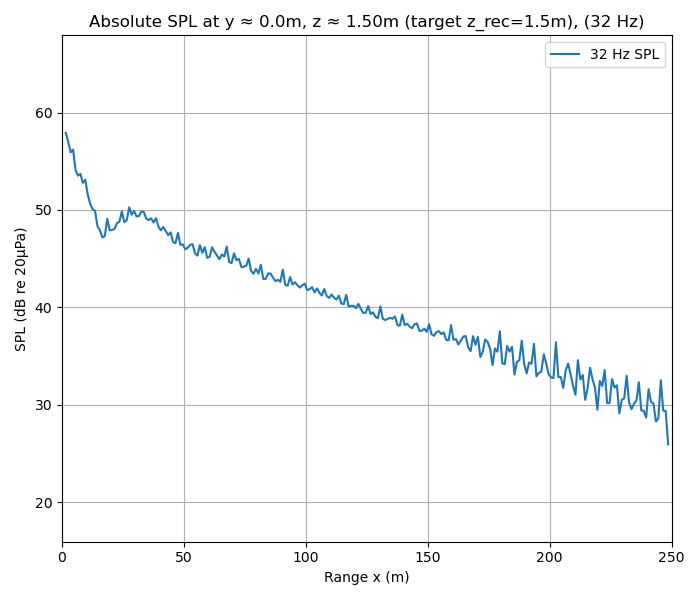

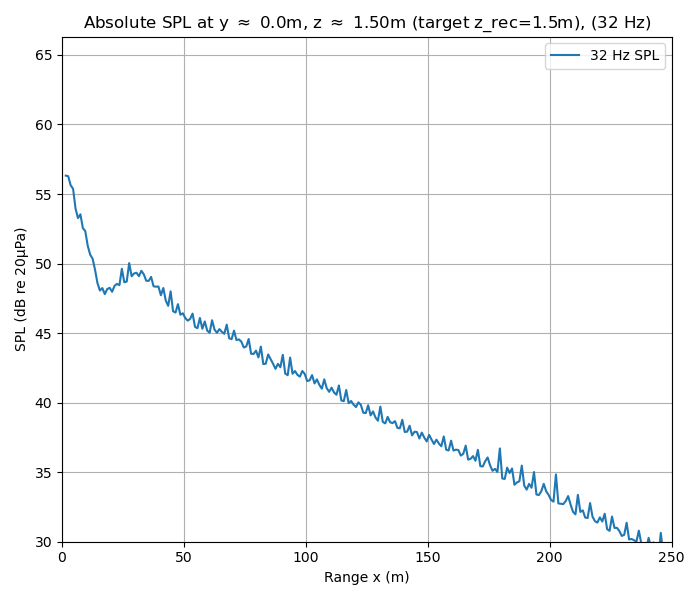

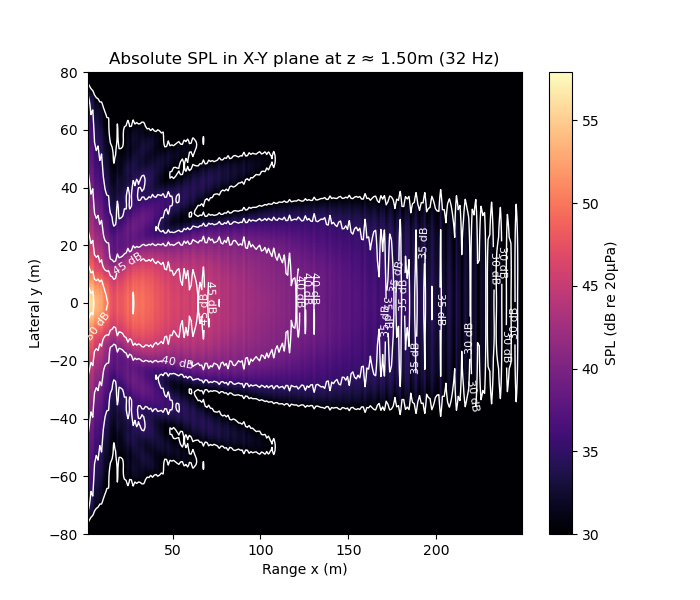

In [7]:
# ---------- VISUALIZATION Horizontal propagation and SPL decay ---------------

title_str_spl = 'Absolute SPL' if CALIBRATE_OUTPUT else 'Relative SPL (Post-Effects)' 

iy_slice_plot_idx = np.argmin(np.abs(y_pp_interp - yS_source_y_center)) if len(y_pp_interp) > 0 else 0
iz_slice_plot_idx_receiver = np.argmin(np.abs(z_pp_interp - z_r_receiver_height)) if len(z_pp_interp) > 0 else 0
iz_slice_plot_idx_source = np.argmin(np.abs(z_pp_interp - hS_source_z)) if len(z_pp_interp) > 0 else 0

if not (0 <= iy_slice_plot_idx < len(y_pp_interp)) and len(y_pp_interp)>0 : iy_slice_plot_idx = 0 
elif len(y_pp_interp) == 0 : iy_slice_plot_idx = -1 # Indicates no valid index

if not (0 <= iz_slice_plot_idx_receiver < len(z_pp_interp)) and len(z_pp_interp)>0: iz_slice_plot_idx_receiver = 0
elif len(z_pp_interp) == 0 : iz_slice_plot_idx_receiver = -1

if not (0 <= iz_slice_plot_idx_source < len(z_pp_interp)) and len(z_pp_interp)>0: iz_slice_plot_idx_source = 0
elif len(z_pp_interp) == 0 : iz_slice_plot_idx_source = -1



plot_y_slice_val = y_pp_interp[iy_slice_plot_idx] if iy_slice_plot_idx != -1 and len(y_pp_interp)>0 else yS_source_y_center
plot_z_slice_receiver_val = z_pp_interp[iz_slice_plot_idx_receiver] if iz_slice_plot_idx_receiver != -1 and len(z_pp_interp)>0 else z_r_receiver_height
plot_z_slice_source_val = z_pp_interp[iz_slice_plot_idx_source] if iz_slice_plot_idx_source != -1 and len(z_pp_interp)>0 else hS_source_z


fig_xy, fig_line = plot_xy_slice(L_pp3D_final_for_analysis, x_pp_interp, y_pp_interp, iy_slice_plot_idx, iz_slice_plot_idx_source, freq, title_str_spl, CALIBRATE_OUTPUT, dim_x, plot_y_slice_val, plot_z_slice_receiver_val, z_r_receiver_height)

fig_line, ax_line = plt.subplots(figsize=(7,6)) 
line_data_available = False
if L_pp3D_final_for_analysis.ndim == 3 and L_pp3D_final_for_analysis.size > 0 and \
    iz_slice_plot_idx_receiver != -1 and 0 <= iz_slice_plot_idx_receiver < L_pp3D_final_for_analysis.shape[0] and \
    iy_slice_plot_idx != -1 and 0 <= iy_slice_plot_idx < L_pp3D_final_for_analysis.shape[1] and \
    L_pp3D_final_for_analysis.shape[2] == len(x_pp_interp) and len(x_pp_interp) > 0:
    
    line_data_spl_plot = L_pp3D_final_for_analysis[iz_slice_plot_idx_receiver, iy_slice_plot_idx, :]
    ax_line.plot(x_pp_interp, line_data_spl_plot, linewidth=1.5, label=f'{freq:.0f} Hz SPL')
    
    min_plot_val = np.nanmin(line_data_spl_plot) if not np.all(np.isnan(line_data_spl_plot)) else 30.0
    max_plot_val = np.nanmax(line_data_spl_plot) if not np.all(np.isnan(line_data_spl_plot)) else 100.0
    ax_line.set_ylim([max(30.0, (min_plot_val if np.isfinite(min_plot_val) else 30.0)-10) , 
                        max(60.0, (max_plot_val if np.isfinite(max_plot_val) else 100.0)+10)])
    ax_line.legend()
    line_data_available = True

if not line_data_available:
    ax_line.text(0.5,0.5, "Line plot SPL data unavailable", ha='center', va='center', transform=ax_line.transAxes)
    ax_line.set_ylim([30,120]) 

ax_line.set_xlim([0, dim_x if dim_x > 0 else 1]); ax_line.grid(True) # Ensure xlim has a positive range
ax_line.set_xlabel('Range x (m)'); ax_line.set_ylabel('SPL (dB re 20µPa)' if CALIBRATE_OUTPUT else 'Relative SPL (dB)')
ax_line.set_title(f'{title_str_spl} at y $\\approx$ {plot_y_slice_val:.1f}m, z $\\approx$ {plot_z_slice_receiver_val:.2f}m (target z_rec={z_r_receiver_height:.1f}m), ({freq:.0f} Hz)')
plt.tight_layout(); plt.show(block=False)

### POLAR PLOT



Created an (161, 249) array
--------------------------------------------------


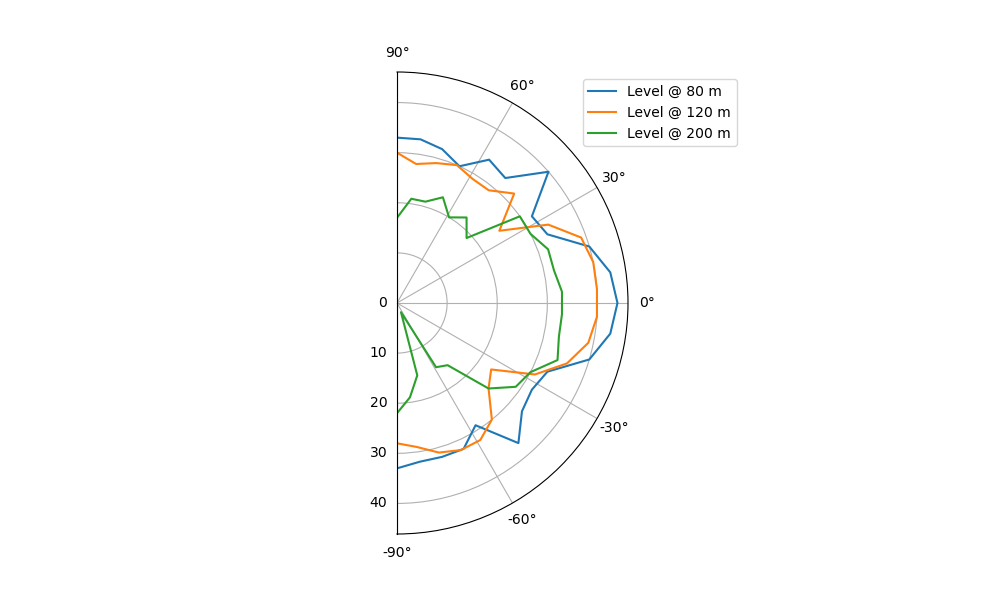

In [8]:
# Define the parameters
array_shape =  L_pp3D_final_for_analysis[2,:,:].shape#(50, 50) #L_pp3D_final_for_analysis[2,:,:]
center_point_1 = (80, 30)
center_point_2 = (80, 70)
center_point_3 = (80, 150)

radius = 50.0

# Tolerance to give the circle's line "thickness".
tolerance = 0.5

# Define the start and end angles for the GAP in the circle (in degrees).
gap_start_angle_deg = 135 
gap_end_angle_deg = 230

# 50x50 array initialized with L_pp3D_final_for_analysis
main_array = np.round(L_pp3D_final_for_analysis[2,:,:])

print(f"Created an {array_shape} array")
print("-" * 50)

# Create coordinate grids.
rows, cols = np.indices(array_shape)

# Calculate the distance of every cell from the center point.
distances_1 = np.sqrt((rows - center_point_1[0])**2 + (cols - center_point_1[1])**2)
distances_2 = np.sqrt((rows - center_point_2[0])**2 + (cols - center_point_2[1])**2)
distances_3 = np.sqrt((rows - center_point_3[0])**2 + (cols - center_point_3[1])**2)

# Create a boolean "mask" for cells that fall on the circle's circumference.
on_the_circle_mask_1 = np.abs(distances_1 - radius) <= tolerance
on_the_circle_mask_2 = np.abs(distances_2 - radius) <= tolerance
on_the_circle_mask_3 = np.abs(distances_3 - radius) <= tolerance

# Calculate the angles for all points to create the arc.
# We get the angle of each point relative to the center.
# `dy` is inverted for standard angle calculation (y-axis points up).
dy_1 = center_point_1[0] - rows 
dx_1 = cols - center_point_1[1]
angles_rad_1 = np.arctan2(dy_1, dx_1)

dy_2 = center_point_2[0] - rows 
dx_2 = cols - center_point_2[1]
angles_rad_2 = np.arctan2(dy_2, dx_2)

dy_3 = center_point_3[0] - rows 
dx_3 = cols - center_point_3[1]
angles_rad_3 = np.arctan2(dy_3, dx_3)

# Convert angles from radians [-pi, pi] to degrees [0, 360] for easier handling.
angles_deg_1 = np.rad2deg(angles_rad_1)
angles_deg_positive_1 = (angles_deg_1 + 360) % 360

angles_deg_2 = np.rad2deg(angles_rad_2)
angles_deg_positive_2 = (angles_deg_2 + 360) % 360

angles_deg_3 = np.rad2deg(angles_rad_3)
angles_deg_positive_3 = (angles_deg_3 + 360) % 360


# Create a mask for the desired arc.
# This logic creates a mask for points OUTSIDE the defined gap.
if gap_start_angle_deg > gap_end_angle_deg:
    # This case handles a gap that crosses the 0/360 degree line
    in_arc_mask_1 = (angles_deg_positive_1 <= gap_start_angle_deg) & (angles_deg_positive_1 >= gap_end_angle_deg)
    in_arc_mask_2 = (angles_deg_positive_2 <= gap_start_angle_deg) & (angles_deg_positive_2 >= gap_end_angle_deg)
    in_arc_mask_3 = (angles_deg_positive_3 <= gap_start_angle_deg) & (angles_deg_positive_3 >= gap_end_angle_deg)
    
else:
    # This case handles a gap that does not cross the 0/360 degree line
    in_arc_mask_1 = (angles_deg_positive_1 <= gap_start_angle_deg) | (angles_deg_positive_1 >= gap_end_angle_deg)
    in_arc_mask_2 = (angles_deg_positive_2 <= gap_start_angle_deg) | (angles_deg_positive_2 >= gap_end_angle_deg)
    in_arc_mask_3 = (angles_deg_positive_3 <= gap_start_angle_deg) | (angles_deg_positive_3 >= gap_end_angle_deg)
    

# Combine the distance and angle masks.
# The final mask is True only for points that are on the circle AND in the desired arc.
final_mask_1 = on_the_circle_mask_1 & in_arc_mask_1
final_mask_2 = on_the_circle_mask_2 & in_arc_mask_2
final_mask_3 = on_the_circle_mask_3 & in_arc_mask_3


# Populate the arc their respective values
num_values_needed_1 = np.sum(final_mask_1)
num_values_needed_2 = np.sum(final_mask_2)
num_values_needed_3 = np.sum(final_mask_3)

hhh_1 = main_array[final_mask_1]
hhh_2 = main_array[final_mask_2]
hhh_3 = main_array[final_mask_3]

data_sliced_1 = hhh_1[::10] 
data_sliced_2 = hhh_2[::10] 
data_sliced_3 = hhh_3[::10] 

data_1 = data_sliced_1
data_2 = data_sliced_2
data_3 = data_sliced_3
N_1 = len(data_1)
N_2 = len(data_2)
N_3 = len(data_3)

# 10° resolution
angles_1 = np.linspace(-np.pi/2, np.pi/2, N_1)   #half‐circle angles from -90° to +90°
angles_2 = np.linspace(-np.pi/2, np.pi/2, N_2)   #half‐circle angles from -90° to +90°
angles_3 = np.linspace(-np.pi/2, np.pi/2, N_3)   #half‐circle angles from -90° to +90°

# find where the maximum is, and roll the data so max moves to the center index
idx_max_1 = np.argmax(data_1)
idx_max_2 = np.argmax(data_2)
idx_max_3 = np.argmax(data_3)

center_idx_1 = N_1 // 2
center_idx_2 = N_2 // 2
center_idx_3 = N_3 // 2

shift = center_idx_1 - idx_max_1
shift = center_idx_2 - idx_max_2
shift = center_idx_3 - idx_max_3

data_centered_1 = data_1 
data_centered_2 = data_2 
data_centered_3 = data_3 

# now plot
fig, ax = plt.subplots(subplot_kw=dict(polar=True), figsize=(10,6))

ax.set_thetamin(-90)
ax.set_thetamax(90)

# PARAMS FOR LEGEND!
spl_80 = {"label": "Level @ 80 m"}
spl_120 = {"label": "Level @ 120 m"}
spl_200 = {"label": "Level @ 200 m"}


ax.plot(angles_1, data_centered_1, linewidth=1.5,label=spl_80["label"])
ax.plot(angles_2, data_centered_2, linewidth=1.5, label=spl_120["label"])
ax.plot(angles_3, data_centered_3, linewidth=1.5, label=spl_200["label"])


# MODIFICATION: Customize Angle Tick Labels ---
# Define the tick positions in degrees 
tick_degrees = [-90, -60, -30, 0, 30, 60, 90]
# Convert the degree positions to radians
tick_radians = np.deg2rad(tick_degrees)
# Create the string labels for the ticks
tick_labels = [f'{deg}°' for deg in tick_degrees]

# Set the tick positions and their corresponding labels
ax.set_xticks(tick_radians)
ax.set_xticklabels(tick_labels)
ax.legend()  # Display the legend to identify the datasets
plt.show()
